# Project (final assessment of STK 353)

Let's discuss the car datasets `2009_honda_accord`, `2009_hyundai_sonata`, and `2009_toyota_corolla`. These datasets contain customer reviews for three different car models from 2009. 

1. As a stakeholder representing these companies, your objective is to determine which car has acheived the highest customer satisfaction rate among the three.

2. Additionally, you want to investigate whether the satisfaction rate for the Honda Accord has improved from 2008 to 2009. To answer this question, you will also need to analyze the dataset `2008_honda_accord`, which consists of customer reviews for the Honda Accord from the year 2008.

3. In the end, your final goal is to categorize the customer reviews for the Honda Accord (only those of the year 2008) into $k$ meaningful groups.

To answer the above questions, please consider the following points:
- a) Obtain the number of comments given in all four reviews and report the results.
- b) In the cleaning process, using lemmatization rather than stemming is recommended (Why?)
- c) During the cleaning process, you also need to remove numbers and HTML tags e.g. `<DOC>, <TEXT>, <AUTHOR>` and similar elements.
- d)  The first two questions can be solved using sentiment analysis techniques.
- e) Create appropriate `wordcloud`s for each part to visualize the most frequent words in the reviews.
- f) Determine the optimal value of $k$ from the set $\{2, 3, 4, 5\}$ in Question 3.
- g) (_optional_) Feel free to obtain any other relevant outputs, such as evaluation metrics or additional plots.
- h) (_optional_) If you find that the algorithm used in Question 3 does not provide satisfactory performance, you can try incorporating the datasets `2008_honda_accord` and `2009_honda_accord` to cluster the reviews again, aiming for better results.

##### Import packages

In [32]:
pip install wordcloud


In [33]:
pip install textblob


Note: you may need to restart the kernel to use updated packages.


In [34]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ks_2samp, poisson
from sklearn.metrics import silhouette_score


import inspect
import statsmodels.api as sm
from scipy.integrate import quad
from scipy.stats import beta
import os
import xml.etree.ElementTree as ET
from textblob import TextBlob


import nltk
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
nltk.download('wordnet') 



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lehar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Test data to see if it works

In [35]:
#Testing if the datasets reads

file_path = "2008_honda_accord (1).txt"  
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        file_contents = file.read()
        
        print(file_contents)
except FileNotFoundError:
    print(f"File '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")




<DOCNO>2008_honda_accord</DOCNO>
<DOC>


Just turned 90K and still pleased. 2nd set of tires 3 weeks ago. If purchasing tires, buy same speed rating as original. 90% interstate driving is returning 32-34 MPG. Oil change by Maintenance Minder averaging 10K intervals. No issues and will probably drive to 200K. Brake pads front and rear once to date.

</DOC>
<DOC>


I've owned three vehicles prior to my 08' Accord. My first love was a Malibu, my second was Olds Alero and finally my Isuzu Ascender. I enjoyed every vehicle but, I had problems with all of the in the first year. I have to say that my Honda by far has been the most reliable. It's quiet, get good gas mileage and looks clean inside and out. I love the new body style and the interior is a simple pleasure except for the center dash. Overall I have had minimal issues and the car performs like a champ. I believe it's in the top four cars for the price range. I don't think I could have made a wiser choice in a vehicle for a single gu

In [36]:
honda_accord_2008_path = "2008_honda_accord (1).txt"  
honda_accord_2009_path = "2009_honda_accord.txt"  
hyundai_sonata_2009_path = "2009_hyundai_sonata.txt"  
toyota_corolla_2009_path = "2009_toyota_corolla.txt"  

data_dict = {}

def read_dataset(file_path, dataset_name):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            file_contents = file.read()
            data_dict[dataset_name] = file_contents
    except FileNotFoundError:
        print(f"File '{file_path}' for '{dataset_name}' was not found.")
    except Exception as e:
        print(f"An error occurred while reading '{dataset_name}': {e}")

# Read and store the content of each dataset
read_dataset(honda_accord_2008_path, "2008 Honda Accord")
read_dataset(honda_accord_2009_path, "2009 Honda Accord")
read_dataset(hyundai_sonata_2009_path, "2009 Hyundai Sonata")
read_dataset(toyota_corolla_2009_path, "2009 Toyota Corolla")

for dataset_name, content in data_dict.items():
    print(f"Dataset: {dataset_name}\n")
    print(content)
    print("\n" + "=" * 50 + "\n")  





Dataset: 2008 Honda Accord

<DOCNO>2008_honda_accord</DOCNO>
<DOC>


Just turned 90K and still pleased. 2nd set of tires 3 weeks ago. If purchasing tires, buy same speed rating as original. 90% interstate driving is returning 32-34 MPG. Oil change by Maintenance Minder averaging 10K intervals. No issues and will probably drive to 200K. Brake pads front and rear once to date.

</DOC>
<DOC>


I've owned three vehicles prior to my 08' Accord. My first love was a Malibu, my second was Olds Alero and finally my Isuzu Ascender. I enjoyed every vehicle but, I had problems with all of the in the first year. I have to say that my Honda by far has been the most reliable. It's quiet, get good gas mileage and looks clean inside and out. I love the new body style and the interior is a simple pleasure except for the center dash. Overall I have had minimal issues and the car performs like a champ. I believe it's in the top four cars for the price range. I don't think I could have made a wiser choice 

# Question 1&2

##### a) Obtain the number of comments given in all four reviews and report the results.

In [37]:
comment_counts = {}

for dataset_name, content in data_dict.items():
    # Split the content by the "<DOC>" tag to count the comments
    comments = content.split("<DOC>")
    # Subtract 1 to exclude the first empty entry before the first "<DOC>"
    comment_count = len(comments) - 1
    comment_counts[dataset_name] = comment_count

for dataset_name, count in comment_counts.items():
    print(f"Number of comments in {dataset_name}: {count}")

Number of comments in 2008 Honda Accord: 540
Number of comments in 2009 Honda Accord: 224
Number of comments in 2009 Hyundai Sonata: 262
Number of comments in 2009 Toyota Corolla: 226


### Cleaned data

In [50]:
honda_accord_2008_path = "2008_honda_accord (1).txt"  
honda_accord_2009_path = "2009_honda_accord.txt"  
hyundai_sonata_2009_path = "2009_hyundai_sonata.txt"  
toyota_corolla_2009_path = "2009_toyota_corolla.txt"  

data_dict = {}

def read_dataset(file_path, dataset_name):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            # Read the content of the file
            file_contents = file.read()
            
            # Clean the content (remove numbers and HTML tags)
            cleaned_content = re.sub(r'<[^>]+>', '', file_contents)  
            cleaned_content = re.sub(r'\d+', '', cleaned_content)  
            
            data_dict[dataset_name] = cleaned_content
    except FileNotFoundError:
        print(f"File '{file_path}' for '{dataset_name}' was not found.")
    except Exception as e:
        print(f"An error occurred while reading '{dataset_name}': {e}")

read_dataset(honda_accord_2008_path, "2008 Honda Accord")
read_dataset(honda_accord_2009_path, "2009 Honda Accord")
read_dataset(hyundai_sonata_2009_path, "2009 Hyundai Sonata")
read_dataset(toyota_corolla_2009_path, "2009 Toyota Corolla")


for dataset_name, content in data_dict.items():
    print(f"Dataset: {dataset_name}\n")
    print(content)
    print("\n" + "=" * 50 + "\n")  

Dataset: 2008 Honda Accord

_honda_accord



Just turned K and still pleased. nd set of tires  weeks ago. If purchasing tires, buy same speed rating as original. % interstate driving is returning - MPG. Oil change by Maintenance Minder averaging K intervals. No issues and will probably drive to K. Brake pads front and rear once to date.





I've owned three vehicles prior to my ' Accord. My first love was a Malibu, my second was Olds Alero and finally my Isuzu Ascender. I enjoyed every vehicle but, I had problems with all of the in the first year. I have to say that my Honda by far has been the most reliable. It's quiet, get good gas mileage and looks clean inside and out. I love the new body style and the interior is a simple pleasure except for the center dash. Overall I have had minimal issues and the car performs like a champ. I believe it's in the top four cars for the price range. I don't think I could have made a wiser choice in a vehicle for a single guy or family vehicle for 

 sentiment analysis techniques.

In [51]:
comment_counts = {}
sentiment_scores = {}

def calculate_sentiment_scores(comment):
    # Replace this with your actual sentiment analysis code or function
    return TextBlob(comment).sentiment.polarity

for dataset_name, content in data_dict.items():
    # Split the content by the "<DOC>" tag to count the comments
    comments = content.split("<DOC>")
    # Subtract 1 to exclude the first empty entry before the first "<DOC>"
    comment_count = len(comments) - 1
    comment_counts[dataset_name] = comment_count

    # Calculate sentiment scores for each comment
    sentiment_scores[dataset_name] = [calculate_sentiment_scores(comment) for comment in comments]


# Display the sentiment scores for each car
for dataset_name, scores in sentiment_scores.items():
    print(f"\nSentiment Scores for {dataset_name}:")
    print(scores)





Sentiment Scores for 2008 Honda Accord:
[0.19881615504642738]

Sentiment Scores for 2009 Honda Accord:
[0.20668009312735838]

Sentiment Scores for 2009 Hyundai Sonata:
[0.26181485049994485]

Sentiment Scores for 2009 Toyota Corolla:
[0.23624491656228325]


##### b)  In the cleaning process, using lemmatization rather than stemming is recommended (Why?)

1. Lemmatization produces valid words by reducing words to their base or dictionary form, resulting in words with semantic meaning.

2. Lemmatized words are more readable and closer to their original form, making text more understandable.

3. Lemmatization is suitable for languages with rich inflection, handling complex word forms more effectively than stemming.


##### c) Create appropriate wordclouds for each part to visualize the most frequent words in the reviews

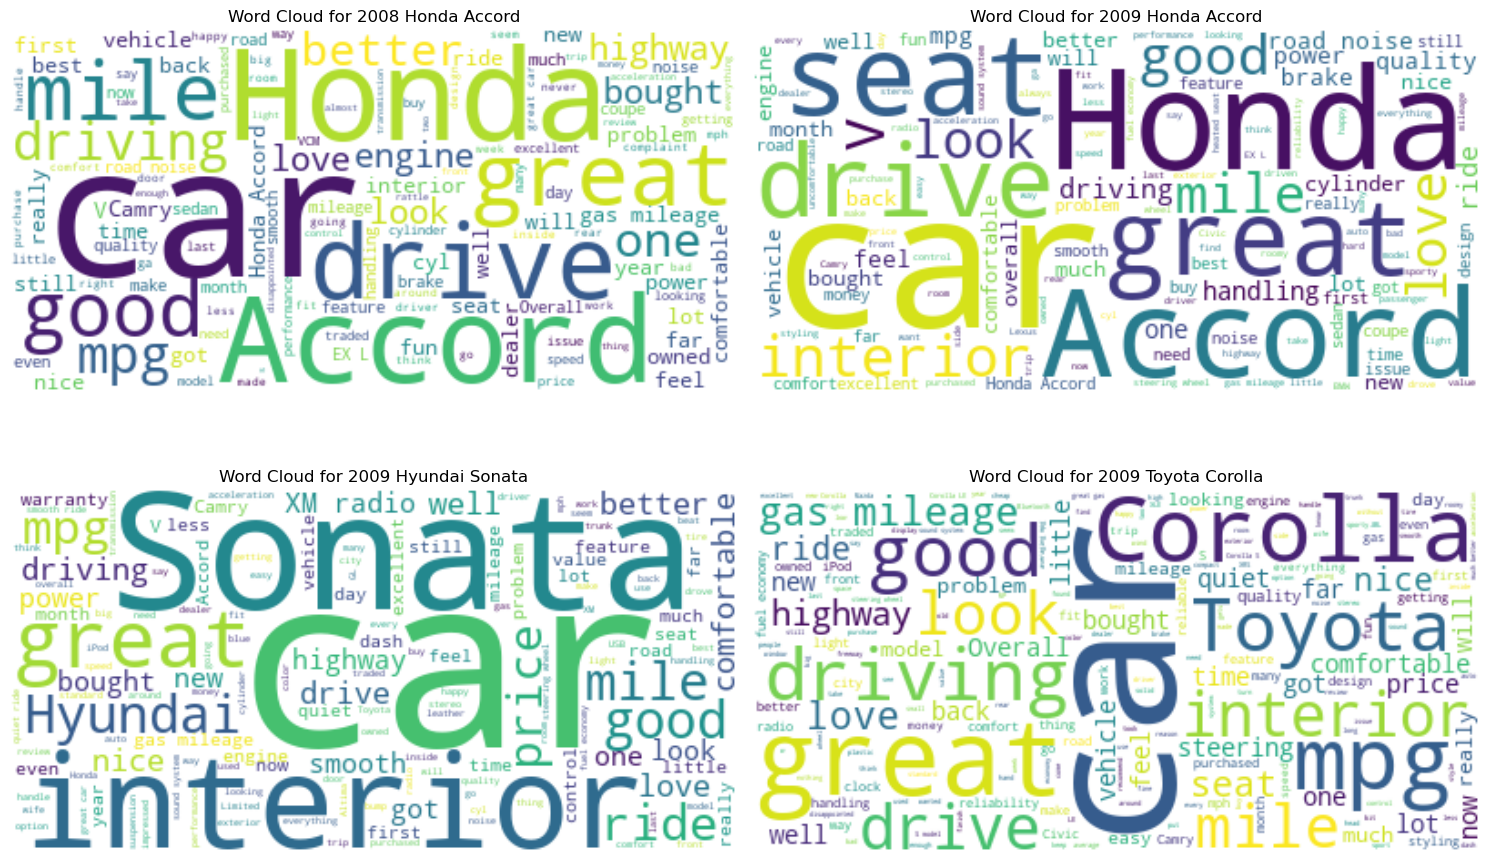

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have the cleaned text for each car in data_dict

# Calculate the number of rows and columns based on the number of datasets
num_datasets = len(data_dict)
num_rows = 2
num_cols = num_datasets // num_rows + (num_datasets % num_rows > 0)

# Set up subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes in case there's only one row or column
axes = np.array(axes).flatten()

for i, (dataset_name, content) in enumerate(data_dict.items()):
    # Generate word cloud
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(content)

    # Plot word cloud in the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Word Cloud for {dataset_name}")

# Adjust layout
plt.tight_layout()
plt.show()



# Question 3

##### d) Determine the optimal value of  𝑘 from the set  {2,3,4,5} in Question 3.

In [53]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming you have data_dict and the necessary imports
honda_2008_data = data_dict["2008 Honda Accord"].splitlines()

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Create the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(honda_2008_data)

# Silhouette Score to measure how similar each data point is to the cluster we have assigned it to
silhouette_scores = []
for k in range(2, 6):
    # Step 1: Apply LDA to identify topics in the customer reviews
    # We apply LDA to our dataset so that we can identify the main topics or in this case the sentiment
    # within our customer review
    lda = LatentDirichletAllocation(n_components=k, random_state=1235)
    sentiment_assignments = lda.fit_transform(tfidf_matrix)
    
    # Step 2: Assign each review to one or more sentiments based on sentiment assignments
    assigned_sentiments = [sentiment_assignments[i].argmax() for i in range(len(honda_2008_data))]
    
    # Step 3: K-Means clustering to cluster reviews based on sentiment assignments
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1235)
    kmeans_clusters = kmeans.fit_predict(sentiment_assignments)
    
    # Step 4: Obtain Silhouette score for each k value
    silhouette_avg = silhouette_score(sentiment_assignments, kmeans_clusters)
    silhouette_scores.append(silhouette_avg)
    print(f"where k Is {k}, The Silhouette Average Score Is {silhouette_avg}")

best_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"The Optimal K Value Is: {best_k}")


where k Is 2, The Silhouette Average Score Is 0.9540947038676025
where k Is 3, The Silhouette Average Score Is 0.9665903171887158
where k Is 4, The Silhouette Average Score Is 0.9564875043389414
where k Is 5, The Silhouette Average Score Is 0.9581344936427967
The Optimal K Value Is: 3


##### (optional) Feel free to obtain any other relevant outputs, such as evaluation metrics or additional plots.

Davies-Bouldin Index: 0.3692674796071557
Calinski-Harabasz Index: 68507.5303990725

Cluster Sizes:
Cluster 0: 2698 reviews
Cluster 1: 514 reviews
Cluster 2: 38 reviews

Davies-Bouldin Index: 0.3692674796071557
Calinski-Harabasz Index: 68507.5303990725


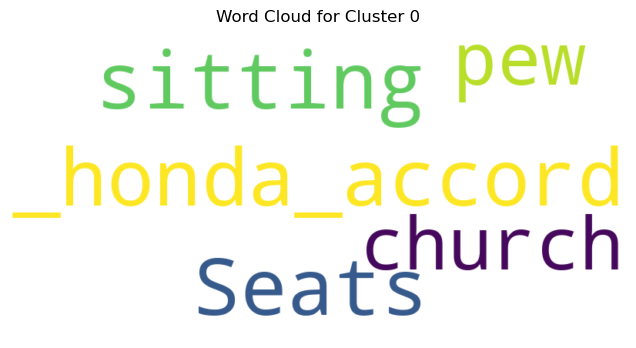

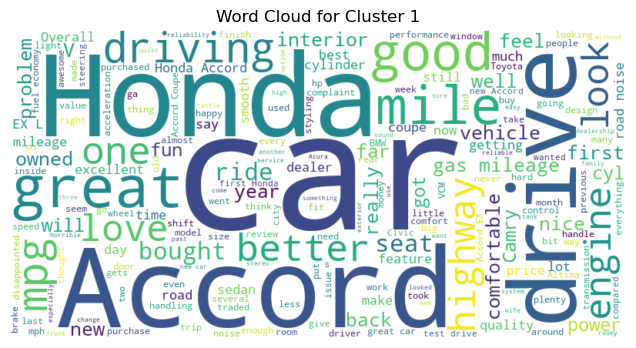

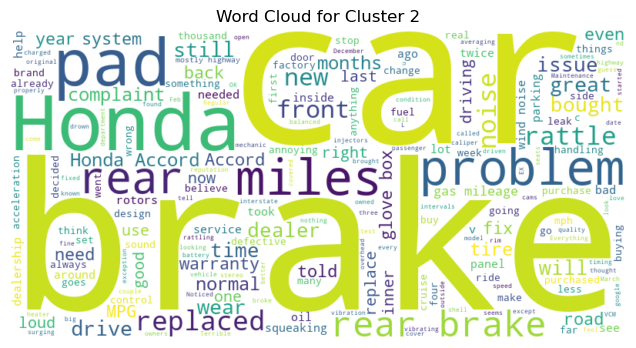

In [54]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

def create_word_clouds(data, labels, k):
    for cluster_label in range(k):
        cluster_data = [text for text, label in zip(data, labels) if label == cluster_label]
        cluster_text = " ".join(cluster_data)
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f'Word Cloud for Cluster {cluster_label}')
        plt.axis("off")
        plt.show()


# Step 3: K-Means clustering to cluster reviews based on sentiment assignments
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=1235)
kmeans_clusters = kmeans.fit_predict(sentiment_assignments)

# Calculate cluster sizes
cluster_sizes = [len(kmeans_clusters[kmeans_clusters == i]) for i in range(best_k)]

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(sentiment_assignments, kmeans_clusters)
print(f"Davies-Bouldin Index: {davies_bouldin}")

# Calculate Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(sentiment_assignments, kmeans_clusters)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

print("\nCluster Sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i}: {size} reviews")

print(f"\nDavies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Create word clouds for each cluster
create_word_clouds(data_dict["2008 Honda Accord"].splitlines(), kmeans_clusters, best_k)

